## Context

We want to scrap details regarding vacation house listings in Imovirtual in the Lisbon district.

import libraries

In [11]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import json
import seaborn as sns
import matplotlib.pyplot as plt

## Get data

### Get links of each listing

We will only look at the first 5 pages of listings. We need to get the links of each listing and comprise the unique links in a structure. The easiest structure is a set, however a set is not subscriptable.

In [12]:
search_url = 'https://www.imovirtual.com/ferias/lisboa/?search%5Bregion_id%5D=11'
urls = []
for i in range(2,6):
    search_url_tmp = search_url + '&page={}'.format(i)
    search_page = requests.get(search_url_tmp)
    soup = BeautifulSoup(search_page.text)
    tmp_urls = [article['data-url'] for article in soup.find_all("article")]
    urls = urls + tmp_urls

urls = list(set(urls))

### Check what the listings look like

The actual text of the listings is too large to print here. However I checked it and most information is inside "target".

There are two ways of proceeding:
1. we convert the whole text to a string and use the split method to find it
2. we use BeautifulSoup and json to find the relevant information. 

Since this is a practice exercise, we will use the second approach.

We start by checking the tags and the tags among them.

In [13]:
def get_listing(url):
    search_page = requests.get(url)
    soup = BeautifulSoup(search_page.text)
    return soup

#### Get tags

In [14]:
soup = get_listing(urls[0])
tmp = [tag.name for tag in soup.find()]
print(str(tmp)) 

['head', 'body']


There are two main tags. The relevant information should be in body. I confirmed by printing the head part, but to keep the notebook readable, I commented that line.

In [15]:
#print(soup.find('head'))
tmp = [tag.name for tag in soup.find('body')]
print(str(tmp))

['div', 'script', 'script', 'script', 'script', 'script', 'script', 'script', 'script', 'script', 'script', 'script', 'script', 'script', 'script', 'script', 'script', 'script', 'script', 'script', 'script', 'script', 'script', 'script', 'script', 'script', 'script', 'script', 'script', 'script', 'script', 'script']


There are several script tags. I printed them (and commented it to avoid the output) and most look empty.
Lets check how many are empty and which ones are not. 

#### Analyze scripts

In [16]:
lst = [t.contents for t in soup.find('body').find_all('script')]

In [17]:
print("The following scripts are not empty:")
count = 0
for i, script in zip (range(50), lst):
    #print(script)
    if not script:
        count = count + 1
    else:
        print("{} - {} of size {}.".format(i, type(script), len(script)))

print("{} scripts are empty.".format(count))

The following scripts are not empty:
0 - <class 'list'> of size 1.
1 - <class 'list'> of size 1.
30 scripts are empty.


In [18]:
print(type(lst[0][0]), type(lst[1][0]))

<class 'bs4.element.Script'> <class 'bs4.element.Script'>


We now have two scripts, which work the same way as a NavigableString. This means we can use the command json.loads which will make it easier to check the information we need.

##### Use json

In [19]:
json.loads(lst[0][0])

{'@context': 'http://schema.org',
 '@type': 'BreadcrumbList',
 'itemListElement': [{'@type': 'ListItem',
   'position': 1,
   'item': {'@id': 'https://www.imovirtual.com/ferias/apartamento/',
    'name': 'Apartamento para férias'}},
  {'@type': 'ListItem',
   'position': 2,
   'item': {'@id': 'https://www.imovirtual.com/ferias/apartamento/lisboa/',
    'name': 'Lisboa'}},
  {'@type': 'ListItem',
   'position': 3,
   'item': {'@id': 'https://www.imovirtual.com/ferias/apartamento/mafra/',
    'name': 'Mafra'}},
  {'@type': 'ListItem',
   'position': 4,
   'item': {'@id': 'https://www.imovirtual.com/ferias/apartamento/ericeira-mafra/',
    'name': 'Ericeira'}},
  {'@type': 'ListItem',
   'position': 5,
   'item': {'@id': 'https://www.imovirtual.com/ferias/apartamento/ericeira-mafra/?search%5Bstreet_id%5D=125735',
    'name': 'Travessa Mar dos Sargaços - Urbanização Ribeira de Ilhas'}},
  {'@type': 'ListItem',
   'position': 6,
   'item': {'@id': '', 'name': 'Ericeira - T2 com vista mar'}}

The first dictionary shows what the main filters should be in order to find this specific listing. 
This is not what we want.

In [20]:
json.loads(lst[1][0]).keys()

dict_keys(['props', 'page', 'query', 'buildId', 'assetPrefix', 'isFallback', 'gssp', 'customServer'])

The second was too large to print here but showed more promising information. By trial and error, this is the relevant part:

In [21]:
dictionary = json.loads(lst[1][0])["props"]['pageProps']['ad']
dictionary.keys()

dict_keys(['id', 'publicId', 'slug', 'advertiserType', 'advertType', 'dateCreated', 'dateModified', 'description', 'developmentId', 'developmentTitle', 'developmentUrl', 'exclusiveOffer', 'externalId', 'features', 'featuresByCategory', 'featuresWithoutCategory', 'openDay', 'redirectUrl', 'referenceId', 'target', 'title', 'topInformation', 'additionalInformation', 'topProjectInformation', 'additionalProjectInformation', 'url', 'status', 'category', 'characteristics', 'images', 'links', 'location', 'cenatorium', 'statistics', 'owner', 'agency', 'seo', 'breadcrumbs', 'userAdverts', 'paginatedUnits', '__typename', 'contactDetails'])

We are interested in the keys 'id', 'advertiserType', 'advertType', 'description', 'target', 'title'. We also want the latitude and longitude, which are inside ['location']['coordinates'].

The value of "target" is also a dictionary. We will put it at the same level as the other keys.

In [22]:
def get_listing_data (dictionary, keys):
    new_keys = keys.copy()
    to_merge1 = {}
    to_merge2 = {}
    if 'target' in new_keys:
        new_keys.remove('target')
        to_merge1 = dictionary['target']
    if 'location' in new_keys:
        new_keys.remove('location')
        to_merge2 = {key: dictionary['location']['coordinates'][key] 
                     for key in ['latitude', 'longitude']} 

    tmp = {key: dictionary[key] for key in new_keys}
    return {**tmp, **to_merge1, **to_merge2}

### Extract data from the listings

In [23]:
keys = ['id', 'advertiserType', 'advertType', 'target', 'title', 'location', 'description', 'status']
dicts = []
for url in urls:
    soup = get_listing(url)
    lst = [t.contents for t in soup.find('body').find_all('script')]
    dictionary = json.loads(lst[1][0])["props"]['pageProps']['ad']
    dicts.append(get_listing_data (dictionary, keys))

### Create Dataframe

In [24]:
df = pd.DataFrame(dicts)

## Clean data

### Check dataframe info

We get the names of columns, amount of missing data and datatypes.

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 39 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  71 non-null     int64  
 1   advertiserType      71 non-null     object 
 2   advertType          71 non-null     object 
 3   title               71 non-null     object 
 4   description         71 non-null     object 
 5   status              71 non-null     object 
 6   Area                71 non-null     object 
 7   AreaRange           71 non-null     object 
 8   Bathrooms_num       67 non-null     object 
 9   Characteristics     40 non-null     object 
 10  City                71 non-null     object 
 11  City_id             71 non-null     object 
 12  Condition           52 non-null     object 
 13  Country             71 non-null     object 
 14  Id                  71 non-null     object 
 15  OfferType           71 non-null     object 
 16  Photo     

Not all these columns should be object.

### Check dataframe head

In [26]:
pd.set_option('display.max_columns', None)
df.head(3)

,id,advertiserType,advertType,title,description,status,Area,AreaRange,Bathrooms_num,Characteristics,City,City_id,Condition,Country,Id,OfferType,Photo,Price,PriceRange,Price_per_m,ProperType,Province,Register_number,RegularUser,Rooms_num,Subregion,Title,categoryId,env,hidePrice,seller_id,user_type,latitude,longitude,Construction_year,Gross_area,Remote_services,Energy_certificate,Terrain_area
0,15454731,business,AGENCY,Ericeira - T2 com vista mar,<p>Apartamento com ampla sala com mesa de refe...,active,100,[51-100],[2],"[cozinha_equipada, estacionamento, gas_canaliz...",ericeira-mafra,11543558,[renovado],Portugal,15454731,ferias,aHR0cHM6Ly9pcmVsYW5kLmFwb2xsby5vbHhjZG4uY29tL3...,840,[501-1000],8.0,apartamento,lisboa,79063/AL,n,[2],mafra,RXJpY2VpcmEgLSBUMiBjb20gdmlzdGEgbWFy,103,production,0,3549447,manager,38.986561,-9.416002,NaN,NaN,NaN,NaN,NaN
1,15456996,business,AGENCY,Ericeira - Casa T3 com jardim,"<p>É uma casa muito acolhedora, com amplo jard...",active,120,[101-150],[2],"[churrasco, estacionamento, jardim, lareira, m...",ericeira-mafra,11543558,[renovado],Portugal,15456996,ferias,aHR0cHM6Ly9pcmVsYW5kLmFwb2xsby5vbHhjZG4uY29tL3...,945,[501-1000],8.0,moradia,lisboa,81875,n,[3],mafra,RXJpY2VpcmEgLSBDYXNhIFQzIGNvbSBqYXJkaW0=,203,production,0,3549447,manager,38.969057,-9.401685,NaN,NaN,NaN,NaN,NaN
2,14399008,business,AGENCY,Pescadata by a Casa das Viagens,Pescadata by a Casa das Viagens<br />\r\n<br /...,active,34.65,[0-50],[1],NaN,ericeira-mafra,11543558,[usado],Portugal,14399008,ferias,aHR0cHM6Ly9pcmVsYW5kLmFwb2xsby5vbHhjZG4uY29tL3...,450,[251-500],13.0,apartamento,lisboa,5667,n,[1],mafra,UGVzY2FkYXRhIGJ5IGEgQ2FzYSBkYXMgVmlhZ2Vucw==,103,production,0,1967995,agency,38.979587,-9.410428,2006,65.9,NaN,NaN,NaN


id and ID look the same. Lets check and if so drop Id.

Some values have parentheses ([]) which may be problematic. Lets remove them. They are only in object datatype columns.

In [27]:
print(len(df[df.id == df.Id]))
df = df.drop('Id', axis=1)

0


### Delete parentheses []

In [28]:
par_cols = ['Bathrooms_num', 'AreaRange', 'Characteristics', 'PriceRange', 'Rooms_num',
           'Energy_certificate', 'Remote_services', 'Condition']

for col in par_cols:
    for i in df.index:
        if type(df.loc[i, col]) == list:
            df.loc[i, col] = ','.join(map(str, df.loc[i, col]))
df.head(3)

,id,advertiserType,advertType,title,description,status,Area,AreaRange,Bathrooms_num,Characteristics,City,City_id,Condition,Country,OfferType,Photo,Price,PriceRange,Price_per_m,ProperType,Province,Register_number,RegularUser,Rooms_num,Subregion,Title,categoryId,env,hidePrice,seller_id,user_type,latitude,longitude,Construction_year,Gross_area,Remote_services,Energy_certificate,Terrain_area
0,15454731,business,AGENCY,Ericeira - T2 com vista mar,<p>Apartamento com ampla sala com mesa de refe...,active,100,51-100,2,"cozinha_equipada,estacionamento,gas_canalizado...",ericeira-mafra,11543558,renovado,Portugal,ferias,aHR0cHM6Ly9pcmVsYW5kLmFwb2xsby5vbHhjZG4uY29tL3...,840,501-1000,8.0,apartamento,lisboa,79063/AL,n,2,mafra,RXJpY2VpcmEgLSBUMiBjb20gdmlzdGEgbWFy,103,production,0,3549447,manager,38.986561,-9.416002,NaN,NaN,NaN,NaN,NaN
1,15456996,business,AGENCY,Ericeira - Casa T3 com jardim,"<p>É uma casa muito acolhedora, com amplo jard...",active,120,101-150,2,"churrasco,estacionamento,jardim,lareira,mobila...",ericeira-mafra,11543558,renovado,Portugal,ferias,aHR0cHM6Ly9pcmVsYW5kLmFwb2xsby5vbHhjZG4uY29tL3...,945,501-1000,8.0,moradia,lisboa,81875,n,3,mafra,RXJpY2VpcmEgLSBDYXNhIFQzIGNvbSBqYXJkaW0=,203,production,0,3549447,manager,38.969057,-9.401685,NaN,NaN,NaN,NaN,NaN
2,14399008,business,AGENCY,Pescadata by a Casa das Viagens,Pescadata by a Casa das Viagens<br />\r\n<br /...,active,34.65,0-50,1,NaN,ericeira-mafra,11543558,usado,Portugal,ferias,aHR0cHM6Ly9pcmVsYW5kLmFwb2xsby5vbHhjZG4uY29tL3...,450,251-500,13.0,apartamento,lisboa,5667,n,1,mafra,UGVzY2FkYXRhIGJ5IGEgQ2FzYSBkYXMgVmlhZ2Vucw==,103,production,0,1967995,agency,38.979587,-9.410428,2006,65.9,NaN,NaN,NaN


### Check object columns

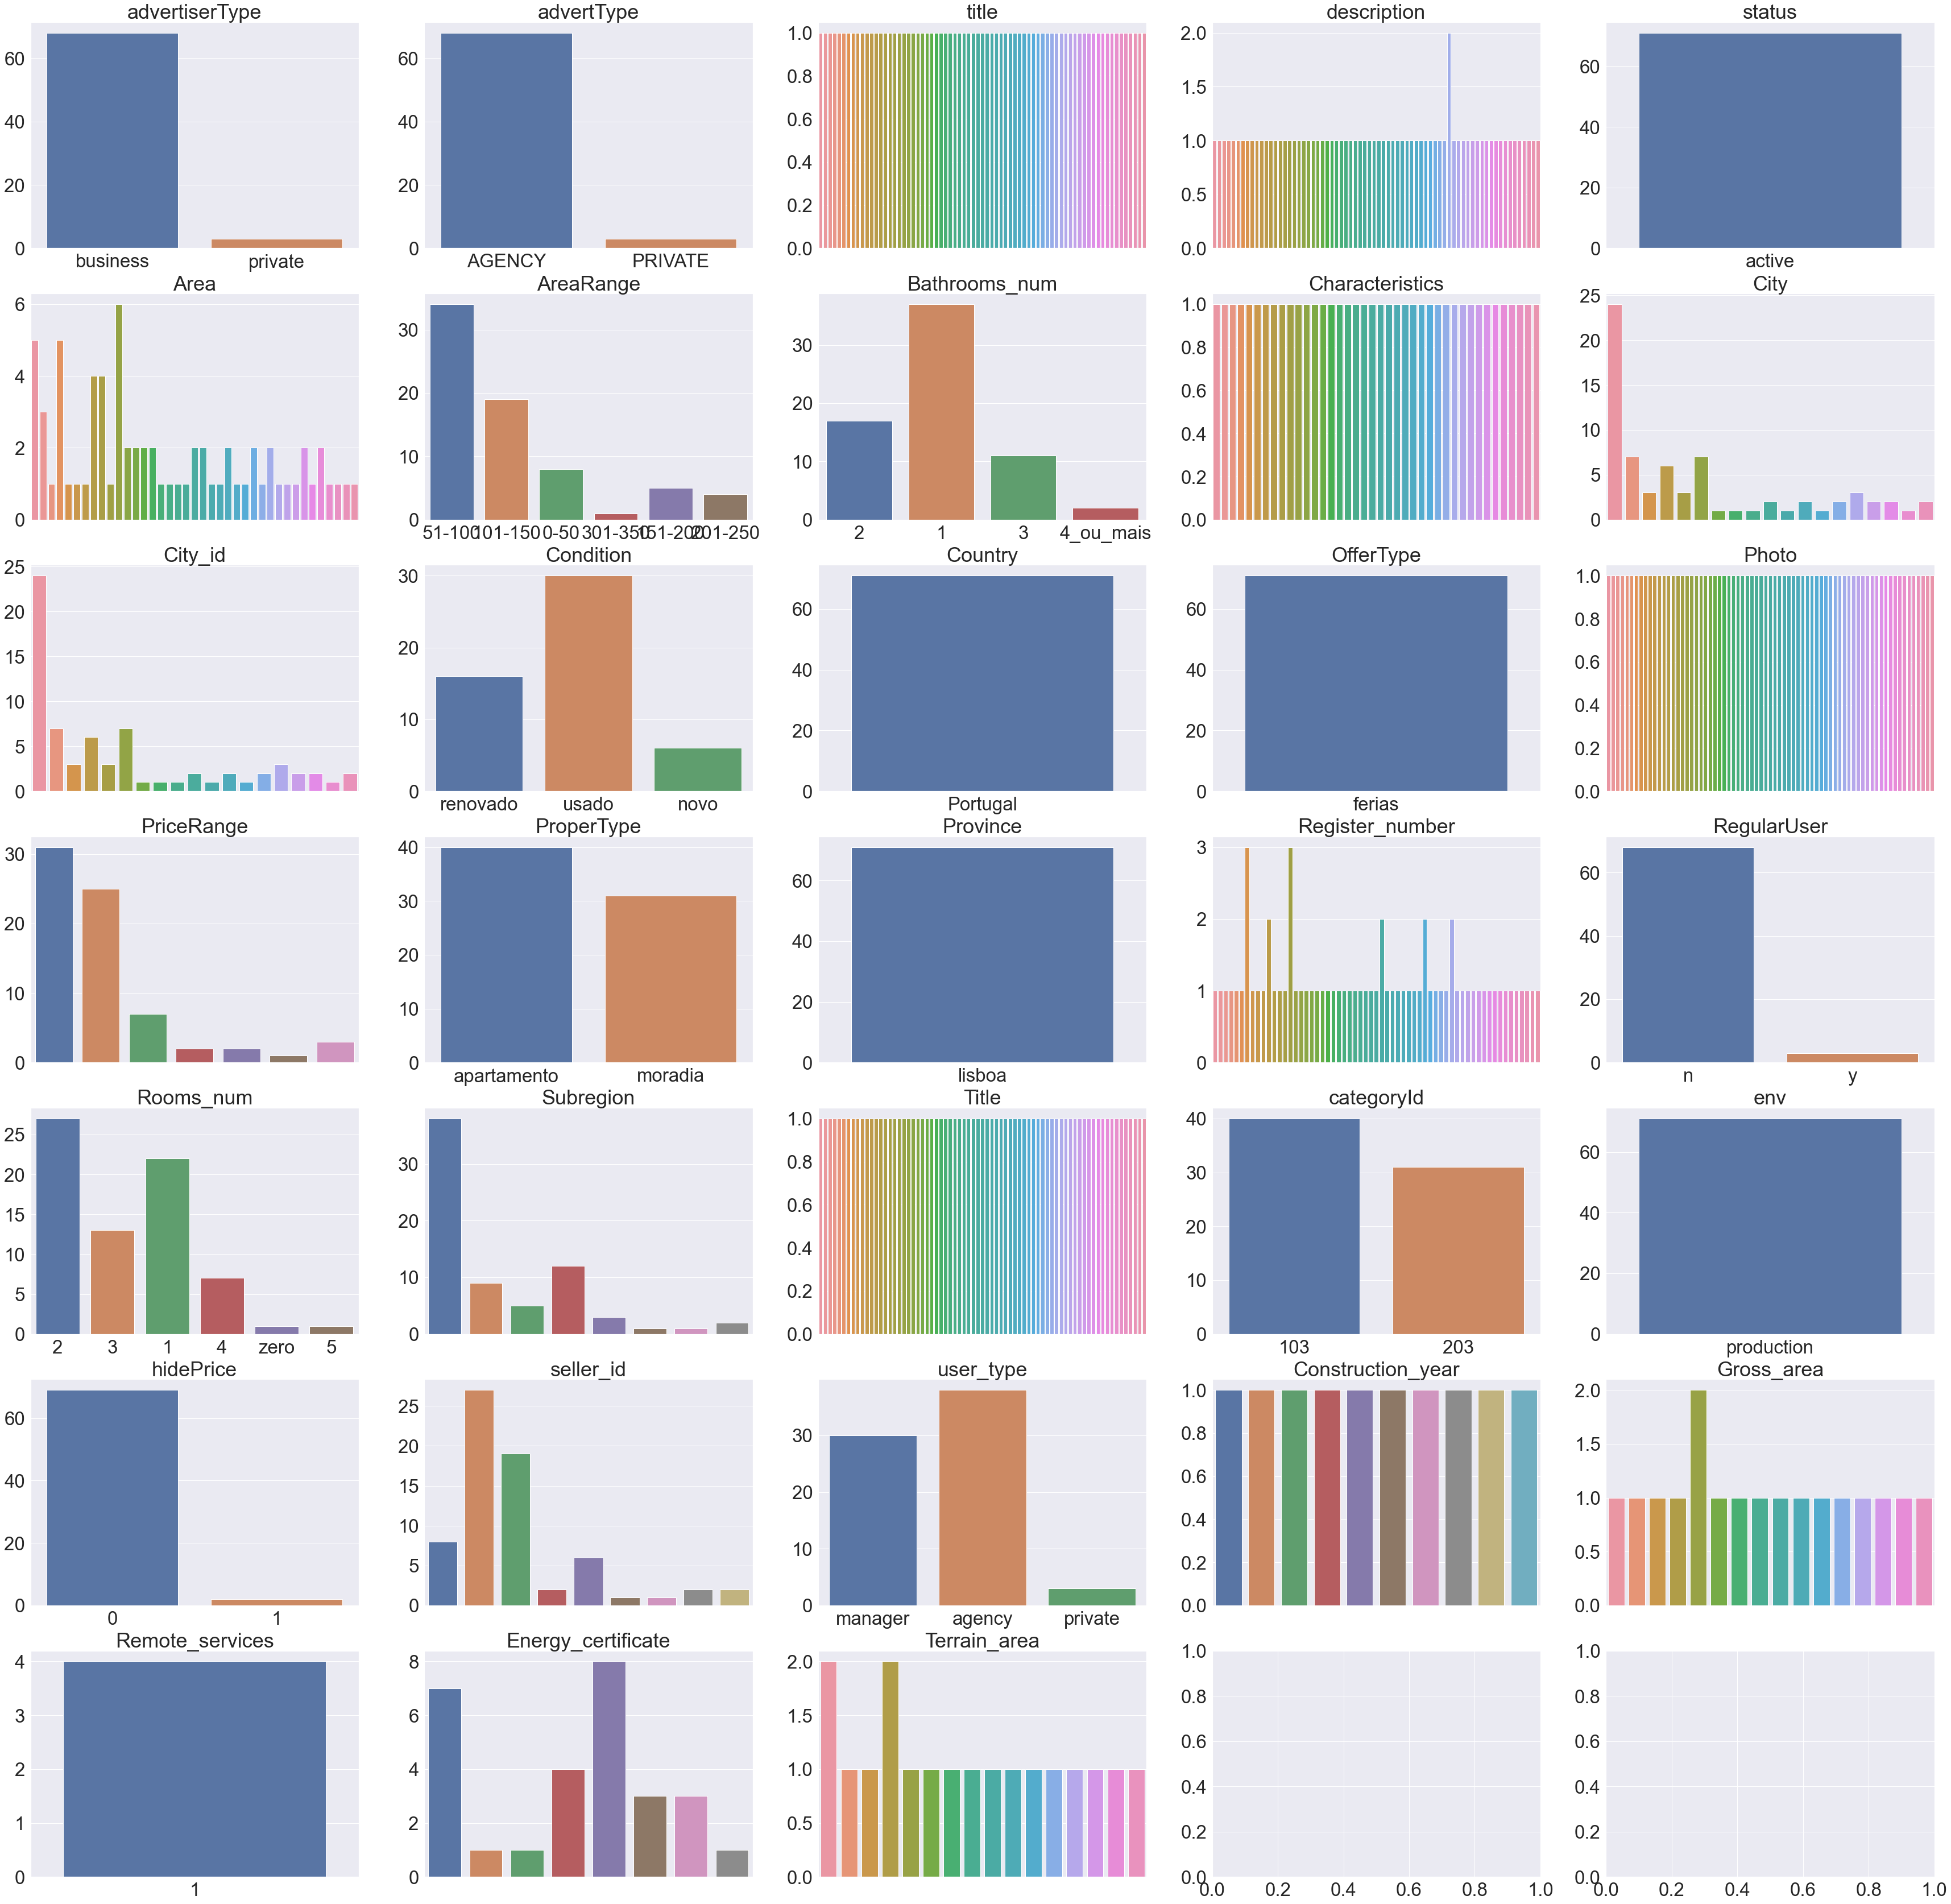

In [29]:
df_obj = df.select_dtypes(include='object')
cols = df_obj.columns

sns.set(font_scale=3)
fig, ax = plt.subplots(7, 5, figsize=(60, 60))
for variable, subplot in zip(cols, ax.flatten()):
    a = sns.countplot(df[variable], ax=subplot)
    if len(df[variable].unique()) > 6:
        a.set(xticklabels=[])
    a.set(xlabel=None)
    a.set(ylabel=None)
    a.set(title=variable)

'status', 'Country', 'OfferType', 'Province', 'env','Remote_services' only have one possible value, so these should be dropped. 'AreaRange', 'PriceRange' can also be dropped since they don't add new indormation.

Bathroom_num can't be changed to numeric. Rooms_num has a 'zero' which should be 0.

'RegularUser' should be a boolean.

'id', 'Area', , 'City_id', 'Construction_year', 'Price', 'Price_per_m', 'RegularUser', 'categoryId', 'hidePrice', 'seller_id', 'latitude', 'longitude', 'Gross_area', 'Terrain_area' should be numeric.

There are two ads with the same description.

In [30]:
df = df.drop(['status', 'Country', 'OfferType', 'Province', 'env','Remote_services',
             'AreaRange', 'PriceRange'], axis=1)

df['Rooms_num'] = df['Rooms_num'].where(df['Rooms_num'] != 'zero', 0)

df['RegularUser'] = df['RegularUser'].map(dict(y=1, n=0))

to_numeric = ['id', 'Area', 'Rooms_num', 'City_id', 'Construction_year', 
              'Price', 'Price_per_m', 'RegularUser', 'categoryId', 
              'hidePrice', 'seller_id', 'latitude', 'longitude', 'Gross_area', 
              'Terrain_area']

df[to_numeric] = df[to_numeric].apply(pd.to_numeric)

In [31]:
df[df['Characteristics'].notnull() & df['Characteristics'].str.contains("box")]

,id,advertiserType,advertType,title,description,Area,Bathrooms_num,Characteristics,City,City_id,Condition,Photo,Price,Price_per_m,ProperType,Register_number,RegularUser,Rooms_num,Subregion,Title,categoryId,hidePrice,seller_id,user_type,latitude,longitude,Construction_year,Gross_area,Energy_certificate,Terrain_area
4,14588725,business,AGENCY,Khall sea view duplex,Khall sea view duplex - Arrendamento de curta ...,135.0,3,"ar_condicionado,elevador,garagem_(box),mobilad...",cascais-e-estoril-cascais,11539464,NaN,aHR0cHM6Ly9pcmVsYW5kLmFwb2xsby5vbHhjZG4uY29tL3...,0,NaN,apartamento,NaN,0,3,cascais,S2hhbGwgc2VhIHZpZXcgZHVwbGV4,103,1,444688.0,agency,38.698716,-9.438081,NaN,135.0,b,NaN
37,15469408,business,AGENCY,Villa Casal de S. Lourenço by A Casa das Viagens,Villa Casal de S. Lourenço by A Casa das Viage...,250.0,4_ou_mais,"cozinha_equipada,jardim,lareira,mobilado,pisci...",encarnacao-mafra,11543556,usado,aHR0cHM6Ly9pcmVsYW5kLmFwb2xsby5vbHhjZG4uY29tL3...,3350,13.0,moradia,108450,0,4,mafra,VmlsbGEgQ2FzYWwgZGUgUy4gTG91cmVuw6dvIGJ5IEEgQ2...,203,0,1967995.0,agency,39.013450,-9.420242,NaN,NaN,NaN,3128.0


### One hot enconding characteristics

In [32]:
def do_one_hot_encoding (df, col):
    tmp = df[col].str.split(",", expand=True)
    cols = pd.unique(tmp.values.ravel('K')) 
    cols = [x for x in cols if (str(x) != 'nan' and str(x) != 'None')]

    df_new = pd.DataFrame(data = np.zeros((len(df), len(cols)), 
                                            dtype=int), columns = cols)
    #print(cols)

    for entry in cols:
        #print(str(entry))
        #if str(entry) != 'nan':        
        ind_tmp = df[df[col].notnull() & df[col].str.contains(entry)].index
        df_new.loc[ind_tmp, entry] = 1


    return df_new    

In [33]:
df_features = do_one_hot_encoding (df, 'Characteristics')
df = df.join([df_features])
df = df.drop('Characteristics', axis=1)

In [34]:
df_features.sum()

cozinha_equipada                                        35
churrasco                                               15
aquecimento_central                                      2
ar_condicionado                                         14
arvores_de_fruto                                         7
vista_cidade                                             4
armario                                                 12
acessibilidade_a_pessoas_com_mobilidade_condicionada     2
condominio_fechado                                      11
casa_das_maquinas                                        1
anexo_habitacional                                       2
estacionamento                                          21
elevador                                                 8
arrecadacao                                              5
gas_canalizado                                          14
mobilado                                                34
jardim                                                  

### Drop duplicates

In [35]:
df[df.duplicated(subset=['description'], keep=False)]

,id,advertiserType,advertType,title,description,Area,Bathrooms_num,City,City_id,Condition,Photo,Price,Price_per_m,ProperType,Register_number,RegularUser,Rooms_num,Subregion,Title,categoryId,hidePrice,seller_id,user_type,latitude,longitude,Construction_year,Gross_area,Energy_certificate,Terrain_area,cozinha_equipada,churrasco,aquecimento_central,ar_condicionado,arvores_de_fruto,vista_cidade,armario,acessibilidade_a_pessoas_com_mobilidade_condicionada,condominio_fechado,casa_das_maquinas,anexo_habitacional,estacionamento,elevador,arrecadacao,gas_canalizado,mobilado,jardim,kitchenette,garagem_(box),lareira,estores_electricos,terraco,caldeira,fibra_optica,detector_incendio,despensa,vista_de_campo_serra,parqueamento_(1carro),cofre,varanda,marquise,vista_de_mar,garagem_exterior,fossa_septica,piscina,suite,vista_de_rio,inserido_em_area_de_paisagem_protegida,parque_infantil,termoacumulador,piscina_privada,detector_inundacao,vedacao,piscina_comum,porta_blindada,portaria,recuperacao_de_calor,video_porteiro,vigilancia_seguranca,quintal_horta,vista_serra,sotao
50,16288496,business,AGENCY,Apartamento T1 | Arroios,"<p>Apartamento ideal para passar umas férias, ...",25.0,1,arroios-lisboa,11540536,renovado,aHR0cHM6Ly9pcmVsYW5kLmFwb2xsby5vbHhjZG4uY29tL3...,340,14.0,apartamento,81778/AL,0,1,lisboa,QXBhcnRhbWVudG8gVDEgfCBBcnJvaW9z,103,0,3873586.0,agency,38.724024,-9.132352,NaN,NaN,c,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
66,16181515,business,AGENCY,Apartamento p/férias | Anjos | Lisboa,"<p>Apartamento ideal para passar umas férias, ...",25.0,1,arroios-lisboa,11540536,renovado,aHR0cHM6Ly9pcmVsYW5kLmFwb2xsby5vbHhjZG4uY29tL3...,343,14.0,apartamento,81778/AL,0,1,lisboa,QXBhcnRhbWVudG8gcC9mw6lyaWFzIHwgQW5qb3MgfCBMaX...,103,0,3873586.0,agency,38.724024,-9.132352,NaN,NaN,NaN,NaN,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


The only additional information of the second entry is the energy certificate.

In [36]:
df.loc[48, 'Energy_certificate'] = df.loc[49, 'Energy_certificate']
df = df.drop(49)

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70 entries, 0 to 70
Data columns (total 81 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   id                                                    70 non-null     int64  
 1   advertiserType                                        70 non-null     object 
 2   advertType                                            70 non-null     object 
 3   title                                                 70 non-null     object 
 4   description                                           70 non-null     object 
 5   Area                                                  70 non-null     float64
 6   Bathrooms_num                                         66 non-null     object 
 7   City                                                  70 non-null     object 
 8   City_id                                               70 non-n

## Save dataframe

In [80]:
df.to_csv('imovirtual.csv')

In [39]:
df.shape

(70, 81)

In [40]:
df[df['Bathrooms_num'] == '4_ou_mais']

,id,advertiserType,advertType,title,description,Area,Bathrooms_num,City,City_id,Condition,Photo,Price,Price_per_m,ProperType,Register_number,RegularUser,Rooms_num,Subregion,Title,categoryId,hidePrice,seller_id,user_type,latitude,longitude,Construction_year,Gross_area,Energy_certificate,Terrain_area,cozinha_equipada,churrasco,aquecimento_central,ar_condicionado,arvores_de_fruto,vista_cidade,armario,acessibilidade_a_pessoas_com_mobilidade_condicionada,condominio_fechado,casa_das_maquinas,anexo_habitacional,estacionamento,elevador,arrecadacao,gas_canalizado,mobilado,jardim,kitchenette,garagem_(box),lareira,estores_electricos,terraco,caldeira,fibra_optica,detector_incendio,despensa,vista_de_campo_serra,parqueamento_(1carro),cofre,varanda,marquise,vista_de_mar,garagem_exterior,fossa_septica,piscina,suite,vista_de_rio,inserido_em_area_de_paisagem_protegida,parque_infantil,termoacumulador,piscina_privada,detector_inundacao,vedacao,piscina_comum,porta_blindada,portaria,recuperacao_de_calor,video_porteiro,vigilancia_seguranca,quintal_horta,vista_serra,sotao
37,15469408,business,AGENCY,Villa Casal de S. Lourenço by A Casa das Viagens,Villa Casal de S. Lourenço by A Casa das Viage...,250.0,4_ou_mais,encarnacao-mafra,11543556,usado,aHR0cHM6Ly9pcmVsYW5kLmFwb2xsby5vbHhjZG4uY29tL3...,3350,13.0,moradia,108450,0,4,mafra,VmlsbGEgQ2FzYWwgZGUgUy4gTG91cmVuw6dvIGJ5IEEgQ2...,203,0,1967995.0,agency,39.013450,-9.420242,NaN,NaN,NaN,3128.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0
60,15469397,business,AGENCY,Aqua Villa by A Casa das Viagens,'Aqua Villa' by A Casa das Viagens<br />\r\n<b...,225.0,4_ou_mais,ericeira-mafra,11543558,usado,aHR0cHM6Ly9pcmVsYW5kLmFwb2xsby5vbHhjZG4uY29tL3...,2800,12.0,moradia,91278,0,4,mafra,QXF1YSBWaWxsYSBieSBBIENhc2EgZGFzIFZpYWdlbnM=,203,0,1967995.0,agency,38.958877,-9.404361,NaN,NaN,NaN,512.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
